In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import linregress
from matplotlib import pyplot as plt

TODO: Gill & Suisted 1978 Coli data.

TODO: add data from Lewis et al. 1992 on Algae?

TODO: add data from Hunter & Rose on Yeast?

In [2]:
# Read and analyze Marr et al. Coli fatty-acid data. 
marr_conds = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='conditions', index_col=0)
marr_fas = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='fatty_acids', index_col=1)
marr_data = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='tables_1_2_3',
                          index_col=1).replace({np.NaN: 0, '': 0}).infer_objects()

In [3]:
# Grab the relevant data and convert to a long-form dataframe. Values are in weight percent. 
marr_data_long = marr_data.reset_index().melt(
    id_vars='short_name', value_vars=marr_data.columns[1:], var_name='condition', value_name='weight_percent')

# Add NC, MW and NOSC information to the long-form DF
NC = marr_fas.loc[marr_data_long.short_name].NC.values
mw = marr_fas.loc[marr_data_long.short_name].mw_daltons.values
NOSC = marr_fas.loc[marr_data_long.short_name].NOSC.values

marr_data_long['NC'] = NC
marr_data_long['mw_daltons'] = mw
marr_data_long['NOSC'] = NOSC

# Calculate the fraction of lipid C atoms on each molecule
# Convert to carbon units and then rescale. 
marr_data_long['C_fraction'] = marr_data_long.weight_percent*NC/mw
C_sums = marr_data_long.groupby('condition').sum().C_fraction
marr_data_long.C_fraction /= C_sums.loc[marr_data_long.condition].values

# Save the long-form version
marr_data_long.to_csv('../data/lipids/Coli/Marr1962_JBac_long.csv', index=False)

In [4]:
# Fraction of C atoms x NOSC is related to total valence e- on that lipid.
# The sum of these terms is just the total lipid NOSC. 
marr_data_long['lipid_NOSC'] = marr_data_long.C_fraction * marr_data_long.NOSC

# Calculate the per-sample total lipid NOSC (with all the assumptions)
total_lipids_nosc = marr_data_long.groupby('condition').agg(dict(lipid_NOSC='sum'))
total_lipids_nosc['growth_rate_hr'] = marr_conds.loc[total_lipids_nosc.index].growth_rate_hr.values
total_lipids_nosc['temp_C'] = marr_conds.loc[total_lipids_nosc.index].temp_C.values
total_lipids_nosc['experiment'] = marr_conds.loc[total_lipids_nosc.index].experiment.values

total_lipids_nosc.to_csv('../data/lipids/Coli/Marr1962_total_lipids_NOSC.csv')
total_lipids_nosc.head()

,lipid_NOSC,growth_rate_hr,temp_C,experiment
condition,,,,
10_C,-1.661453,NaN,10,temp
10_C_rich,-1.660531,NaN,10,temp_rich
15_C,-1.664918,NaN,15,temp
20_C,-1.670111,NaN,20,temp
20_C_rich,-1.665985,NaN,20,temp_rich


<AxesSubplot: xlabel='growth_rate_hr', ylabel='lipid_NOSC'>

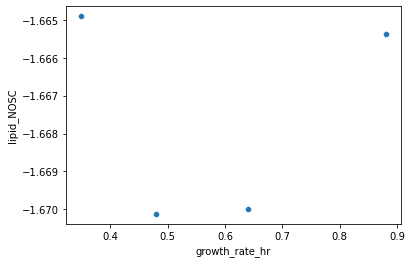

In [5]:
sns.scatterplot(data=total_lipids_nosc, x='growth_rate_hr', y='lipid_NOSC')

<AxesSubplot: xlabel='temp_C', ylabel='lipid_NOSC'>

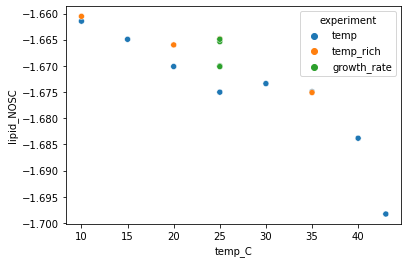

In [6]:
sns.scatterplot(data=total_lipids_nosc, x='temp_C', y='lipid_NOSC', hue='experiment')

In [7]:
# Interested in the change in growth rate in minimal glucose medium over these temperature intervals.
# Lipid data from Marr is in glucose minimal medium with 0.2%.
# Ryals et al 1952 -- 0.2% glucose, w/v. Growth monitored by OD460. 
# 
ryals_gr = pd.read_excel('../data/growth_rates/Coli/Ryals1982_JBac.xlsx')
# Gill 1985 -- 0.01 g/L glucose in minimal medium = 0.1% w/v.
# Water-jacketed temp control. Growth monitored by OD 550. 
gill_gr = pd.read_excel('../data/growth_rates/Coli/Gill1985_FoodMicro.xlsx')

gill_gr['delta_mu'] = gill_gr.growth_rate_hr - gill_gr.growth_rate_hr.min()
ryals_gr['delta_mu'] = ryals_gr.growth_rate_hr - ryals_gr.growth_rate_hr.min()


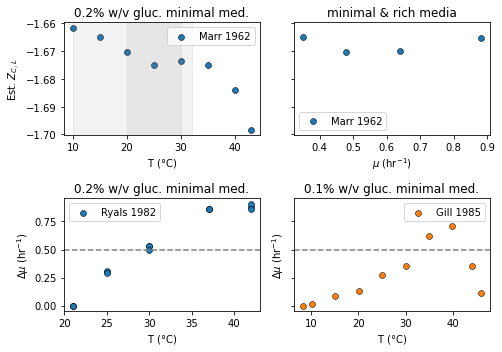

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(7, 5), sharey='row')
pal = sns.color_palette()

plt.sca(axs[0, 0])
plt.title('0.2% w/v gluc. minimal med.')
mask = total_lipids_nosc.experiment == 'temp'
plt.scatter(total_lipids_nosc[mask].temp_C, total_lipids_nosc[mask].lipid_NOSC,
            label='Marr 1962', edgecolor='k', lw=0.5, color=pal[0])
plt.axvspan(10, 32, color='grey', alpha=0.1)
plt.axvspan(20, 30, color='grey', alpha=0.1)
plt.xlabel('T ($\degree$C)')
plt.ylabel('Est. $Z_{C,L}$')
plt.legend()

plt.sca(axs[0, 1])
plt.title('minimal & rich media')
mask = total_lipids_nosc.experiment == 'growth_rate'
plt.scatter(total_lipids_nosc[mask].growth_rate_hr, total_lipids_nosc[mask].lipid_NOSC,
            label='Marr 1962', edgecolor='k', lw=0.5, color=pal[0])
plt.xlabel('$\mu$ (hr$^{-1}$)')
plt.legend()

plt.sca(axs[1, 0])
plt.title('0.2% w/v gluc. minimal med.')
plt.scatter(ryals_gr.temp_C, ryals_gr.delta_mu, label='Ryals 1982',
            color=pal[0], edgecolor='k', lw=0.5)
plt.axhline(0.5, ls='--', color='grey')
plt.xlabel('T ($\degree$C)')
plt.ylabel('$\Delta\mu$ (hr$^{-1}$)')
plt.legend()


plt.sca(axs[1, 1])
plt.title('0.1% w/v gluc. minimal med.')
plt.scatter(gill_gr.temp_C, gill_gr.delta_mu, label='Gill 1985',
            color=pal[1], edgecolor='k', lw=0.5)
plt.axhline(0.5, ls='--', color='grey')
plt.xlabel('T ($\degree$C)')
plt.ylabel('$\Delta\mu$ (hr$^{-1}$)')
plt.legend()

plt.tight_layout()
plt.savefig('../output/lipids_growth_temp.png', facecolor='w', dpi=300)
plt.show()

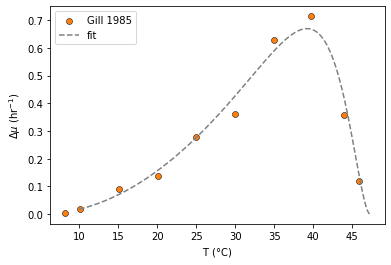

In [9]:
plt.scatter(gill_gr.temp_C, gill_gr.growth_rate_hr, label='Gill 1985',
            color=pal[1], edgecolor='k', lw=0.5)
# Model from Gill 1985, parameters in Table 1
b = 0.0262
c = 0.298
Tmax = 47.3
Tmin = 4.9 

temps = np.arange(10, Tmax, 0.1)
RHS = b*(temps-Tmin)*(1-np.exp(c*(temps-Tmax)))
pred_mu = np.power(RHS, 2)

plt.plot(temps, pred_mu, ls='--', c='grey', label='fit')
plt.xlabel('T ($\degree$C)')
plt.ylabel('$\Delta\mu$ (hr$^{-1}$)')
plt.legend()
plt.show()

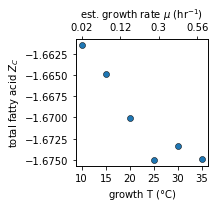

In [10]:
plt.figure(figsize=(3,3))
pal = sns.color_palette()

mask = total_lipids_nosc.experiment == 'temp'
mask = np.logical_and(mask, total_lipids_nosc.temp_C < 36)
plt.scatter(total_lipids_nosc[mask].temp_C, total_lipids_nosc[mask].lipid_NOSC,
            label='Marr 1962', edgecolor='k', lw=0.5, color=pal[0])

plt.xlabel('growth T ($\degree$C)')
plt.ylabel('total fatty acid $Z_{C}$')
xlim = plt.xlim()
temps = np.arange(10, 36, 5)
plt.xticks(temps)

plt.twiny()
temps = np.arange(10, 36, 8)
RHS = b*(temps-Tmin)*(1-np.exp(c*(temps-Tmax)))
pred_mu = np.power(RHS, 2)
plt.xticks(temps, np.round(pred_mu, 2))
plt.xlim(xlim)
plt.xlabel('est. growth rate $\mu$ (hr$^{-1}$)')

plt.tight_layout()
plt.savefig('../output/lipids_coli_presentation.png', facecolor='w', dpi=300)
plt.savefig('../output/lipids_coli_presentation.pdf', dpi=600)

plt.show()